In [1]:
import sys
sys.path.insert(1, '/Users/Andrew/Documents/PhD/Scripts/Python/pygplates_rev12')
import pygplates
import numpy as np
import glob
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap, shiftgrid

%matplotlib inline

/Users/Andrew/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def Get_FZ_Directions(X1,Y1,X2,Y2):
    long1 = np.radians(X1)
    long2 = np.radians(X2)
    lat1 = np.radians(Y1)
    lat2 = np.radians(Y2)

    bearing = np.arctan2(np.sin(long2-long1)*np.cos(lat2), np.cos(lat1)*np.sin(lat2)-np.sin(lat1)*np.cos(lat2)*np.cos(long2-long1))
    bearing = np.degrees(bearing)
    bearing = (bearing + 360) % 360

    return bearing

In [3]:
def poles_of_rotation(to_time, from_time, delta_time,rotation_model, moving_plate, fixed_plate):

    #loop through a rotation in specific time intervals to extract poles of rotation

    #create variables
    Lats = []
    Longs = []
    Angles = []
    time_change = []
    
    for time in np.arange(to_time,from_time,delta_time):

        to_time = time
        from_time = time+delta_time
        stage_rotation = rotation_model.get_rotation(to_time,moving_plate,from_time,fixed_plate)

        pole_lat,pole_lon,pole_angle = stage_rotation.get_lat_lon_euler_pole_and_angle_degrees()

        #to make sure that all poles are expressed in the same hemisphere
        if pole_angle < 0:
            pole_lat = -1*pole_lat
            pole_lon = pole_lon-180
            pole_angle = -1*pole_angle


        time_change.append(from_time)
        #print 'Time interval = ',time,'-',time+delta_time,', Stage Pole Lat,Lon,Angle = %f,%f,%f ' % (pole_lat,pole_lon,pole_angle)
        Lats.append(pole_lat)
        Longs.append(pole_lon)
        Angles.append(np.radians(pole_angle))

    # These next lines are necessary becuase the answers come out in the northern hemisphere, 
    # need to check convention
    Longs = np.add(Longs,180.)
    Lats = np.multiply(Lats,-1)
    
    return Longs, Lats, Angles, time_change

In [4]:
def plotting_geometries(rotation_model, topology_features, time, delta_time):
    
    #extract geometries from a reconstructed file for plotting
    
    all_reconstructed_points = []
    all_velocities = []
    xy_reconstructed_points = []
    
    for feature in topology_features:

        # We need the feature's plate ID to get the equivalent stage rotation of that tectonic plate.
        domain_plate_id = feature.get_reconstruction_plate_id()

        # Get the rotation of plate 'domain_plate_id' from present day (0Ma) to 'reconstruction_time'.
        equivalent_total_rotation = rotation_model.get_rotation(time, domain_plate_id)

        # Get the rotation of plate 'domain_plate_id' from 'reconstruction_time + delta_time' to 'reconstruction_time'.
        equivalent_stage_rotation = rotation_model.get_rotation(time, domain_plate_id, time + delta_time)

        for geometry in feature.get_geometries():

            # Reconstruct the geometry to 'reconstruction_time'.
            reconstructed_geometry = equivalent_total_rotation * geometry
            reconstructed_points = reconstructed_geometry.get_points()
            xy_reconstructed_points = reconstructed_points.to_lat_lon_array()

            all_reconstructed_points.append(xy_reconstructed_points)

    poly_longs = []
    poly_lats = []
    for i in all_reconstructed_points:
        j = i[:,0]
        k = i[:,1]
        poly_longs.append(k)
        poly_lats.append(j)
        
    return poly_lats, poly_longs, all_reconstructed_points

In [5]:
def wrapping_polysomethings(poly_lats, poly_longs):
    #
    #needs pygplates
    #

    latitudes = np.asarray(poly_lats)
    longitudes = np.asarray(poly_longs)
    polyline = pygplates.PolylineOnSphere(zip(latitudes, longitudes))
    wrapped_polylines = date_line_wrapper.wrap(polyline)
    for wrapped_polyline in wrapped_polylines:
        wrapped_points = wrapped_polyline.get_points()
        wrapped_points_lat = []
        wrapped_points_lon = []
        for wrapped_point in wrapped_points:
            wrapped_point_lat, wrapped_point_lon = wrapped_point.get_latitude(), wrapped_point.get_longitude()
            wrapped_points_lat.append(wrapped_point_lat)
            wrapped_points_lon.append(wrapped_point_lon)

        wrapped_points_lat = np.array(wrapped_points_lat)
        wrapped_points_lon = np.array(wrapped_points_lon)

        return wrapped_points_lat, wrapped_points_lon

In [6]:
#load single rotation file for testing
rotation_model = pygplates.RotationModel('/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Kinematic_tests/Aus-Laurentia_725-AUSMEX.rot')

#set path to topologies
input_topology_filename = '/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Rod-Gondw_intraplate.gpml'
input_flowlines_filename = '/Users/Andrew/Documents/PhD/Models/Rodinia_Models/Lis_model_amends/Merdith_Models/SWEAT_20151020/Kinematic_tests/Flowlines/725_Flowlines_AUSMEX.gpml'
# Load the topological plate polygon features.
topology_features = pygplates.FeatureCollection(input_topology_filename)
flowline_features = pygplates.FeatureCollection(input_flowlines_filename)

#parameters
centre_longitude = 180
fixed_plate = 1001 #
moving_plate = 8004 #Australia (+Antarctica)
    
date_line_wrapper = pygplates.DateLineWrapper(centre_longitude)

# Parameters required to define a flowline (as in GPlates)
left_plate = 8004
right_plate = 1001
to_time_zero = 0
delta_time_flowline = 5
reconstruction_time_flowline = 650
rifting_time=725

title_font_size = 35
ticks_font_size = 25
axis_font_size = 30

CList_1 = 'r', 'o', 'g'
CList = ['Red','Orange','Green']

In [7]:
times = np.arange(to_time_zero,rifting_time+delta_time_flowline,delta_time_flowline)     # using numpy to get a list of times in delta_time_flowline increments
cb_times = np.arange(reconstruction_time_flowline,rifting_time+delta_time_flowline,delta_time_flowline) #for colorbar plotting
time_intervals = np.diff(cb_times)

In [8]:
cb_times

array([650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710,
       715, 720, 725])

In [9]:
reconstructed_flowlines = []
pygplates.reconstruct(flowline_features, rotation_model, reconstructed_flowlines, reconstruction_time_flowline, reconstruct_type=pygplates.ReconstructType.flowline)

In [10]:
reconstructed_flowlines

[ 7.94118208  7.94118208  7.94118208  7.94118208  7.94118208  7.94118208
  7.94118208  7.94118208  7.94118208  7.94118208  7.94118208  7.94118208
  7.94118208  7.94118208  7.94118208]
0
1
2


(725, 650)

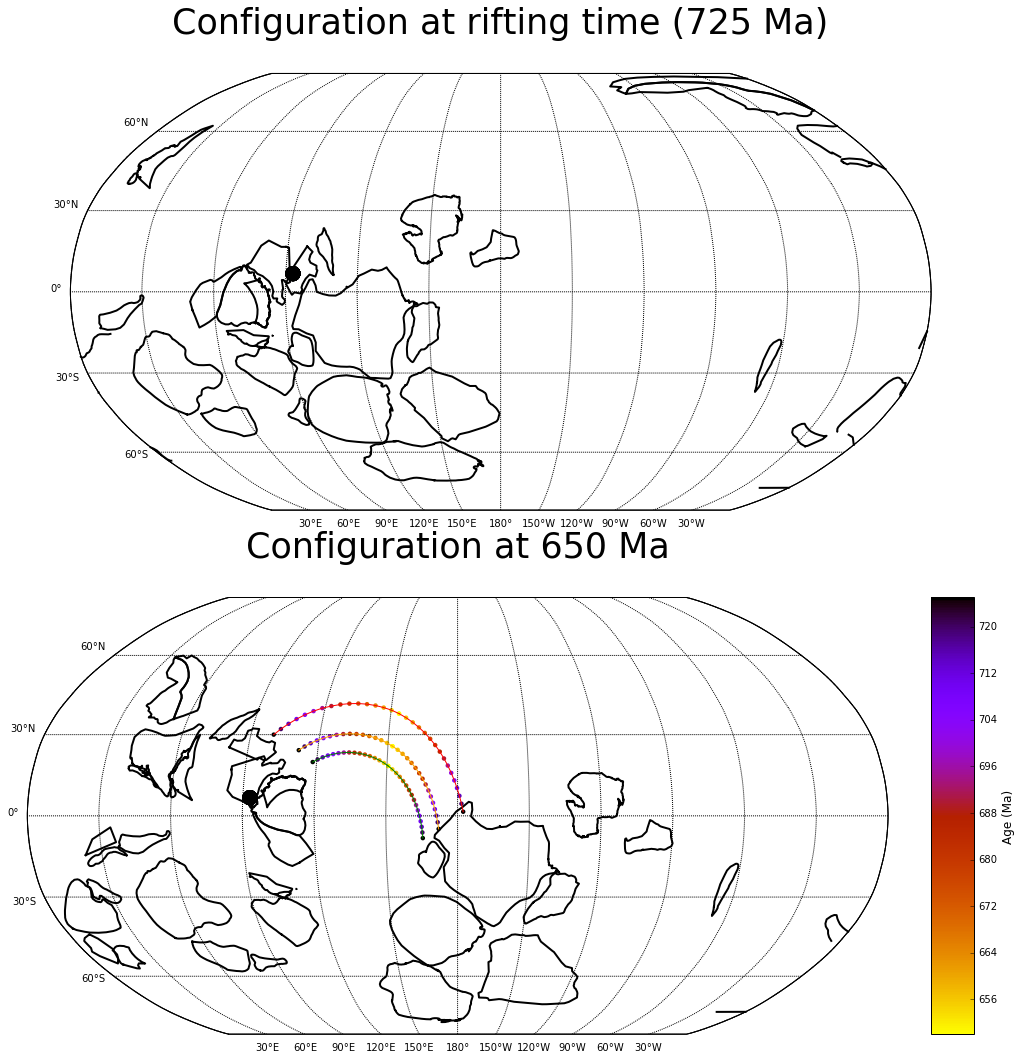

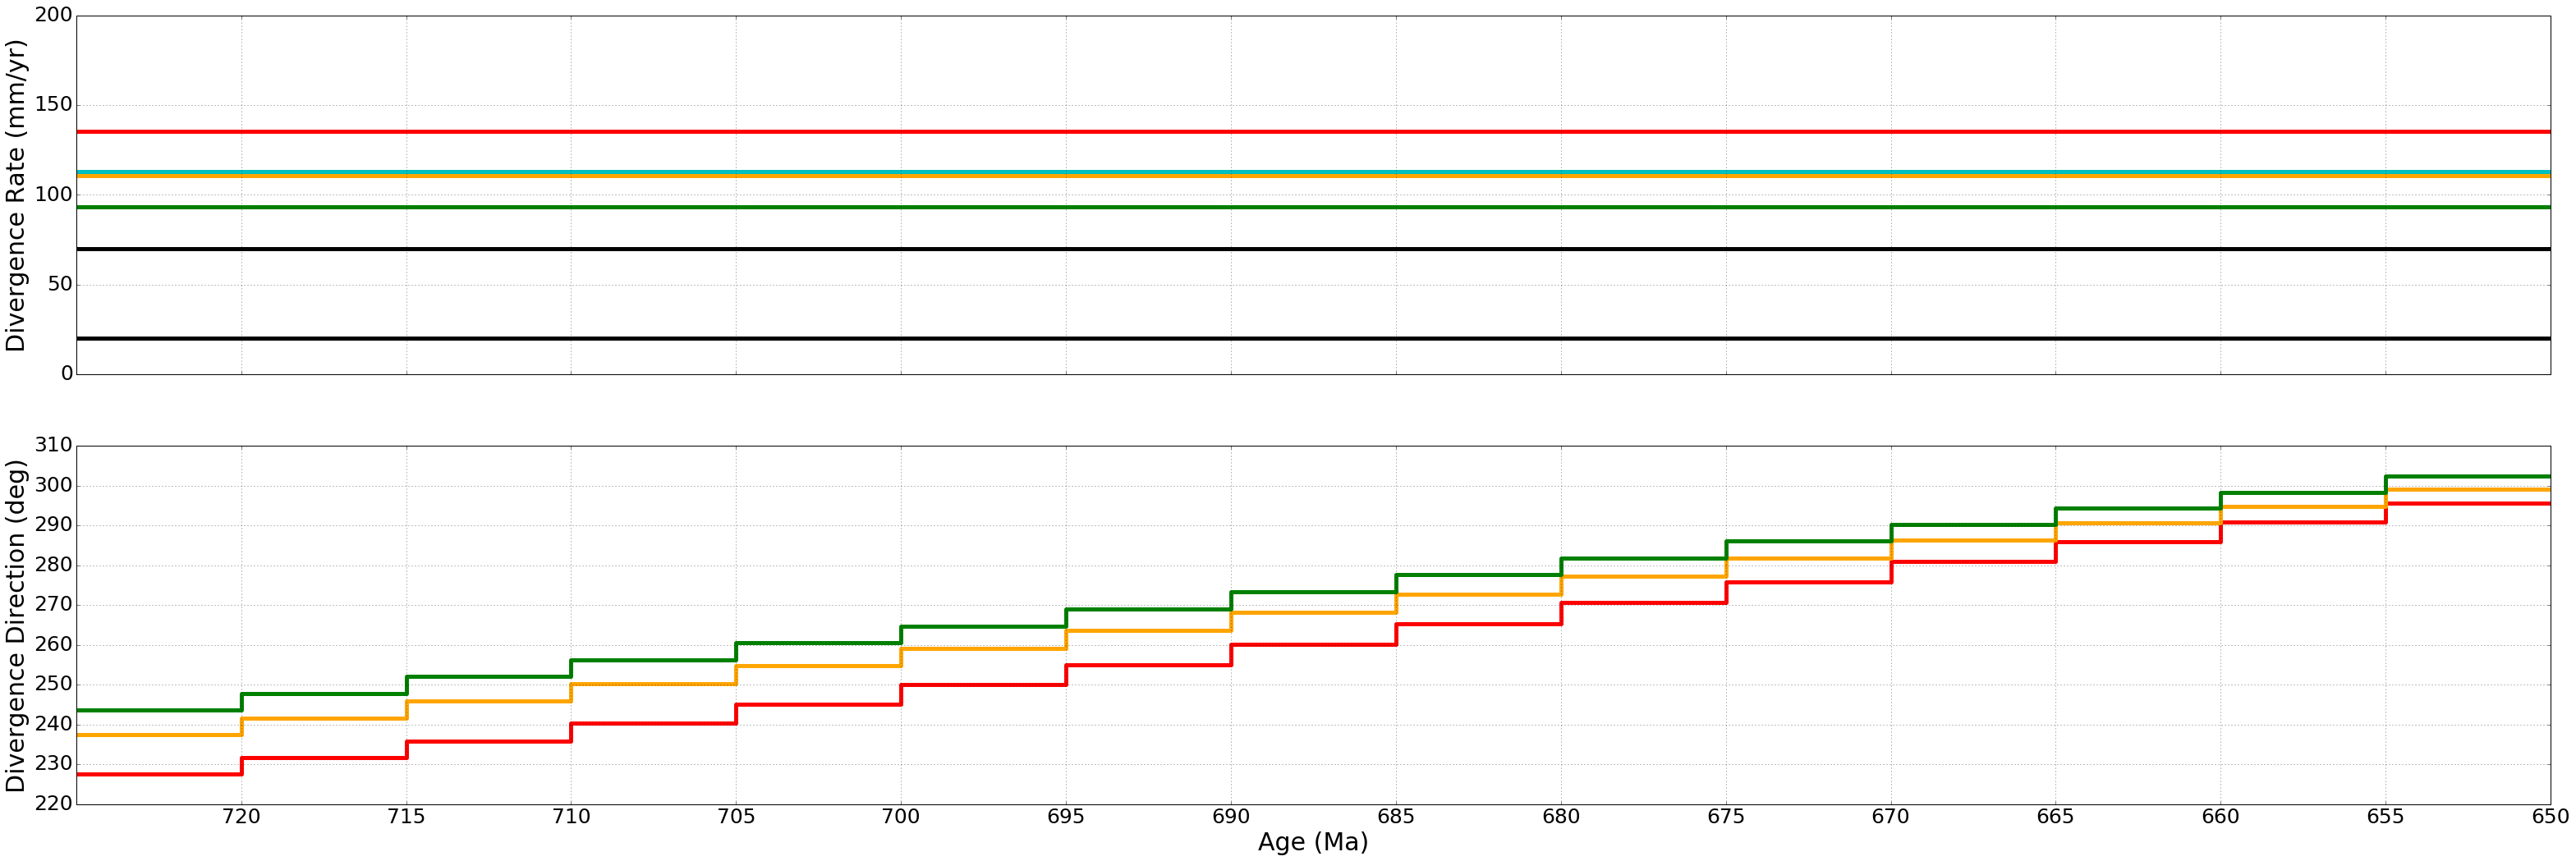

In [11]:
lats_650, longs_650, all_reconstructed_points_650 = plotting_geometries(rotation_model, topology_features, reconstruction_time_flowline, delta_time_flowline) #geometry positions      
Longs, Lats, Angles, time_change = poles_of_rotation(reconstruction_time_flowline, rifting_time, delta_time_flowline, rotation_model, moving_plate, fixed_plate) #euler pole positions
angles_degrees = np.degrees(Angles)

threshold = 5
angles_degrees = np.degrees(Angles)
print angles_degrees
marker_size = []

for val in angles_degrees:
    if val > threshold:
        marker_size.append(20)
    else:
        marker_size.append(5)

marker_size = np.array(marker_size)

fig = plt.figure(figsize=(36*1.5,24*1.5),dpi=300)
plt.subplot(411)
map_1 = Basemap(resolution='c',projection='robin',lon_0=180.)
map_1.drawmeridians(np.arange(0, 360, 30),labels=[0,0,0,1],fontsize=10)
map_1.drawparallels(np.arange(-90, 90, 30), labels=[1,0,0,0],fontsize=10)
clip_path = map_1.drawmapboundary(fill_color='white')
plt.title('Configuration at rifting time (' + str(rifting_time) +' Ma)', fontsize=title_font_size, y=1.08)

lats_rifting, longs_rifting, all_reconstructed_points_rifting = plotting_geometries(rotation_model, topology_features, rifting_time, delta_time_flowline) #geometry positions      

for i,j in zip(lats_rifting, longs_rifting):
    wrapped_points_lat, wrapped_points_lon = wrapping_polysomethings(i, j)

    plt.subplot(411)
    x_geom,y_geom = map_1(wrapped_points_lon, wrapped_points_lat)
    map_1.plot(x_geom, y_geom, color='k', linewidth=2)

    
plt.subplot(411)
x,y = map_1(Longs,Lats)
map_1.plot(x, y, 'r', clip_path=clip_path,zorder=0)
map_1.scatter(x, y, s=(marker_size*10), c=np.arange(reconstruction_time_flowline, rifting_time, delta_time_flowline), marker = 'o', cmap=plt.cm.gnuplot_r, edgecolor='k', clip_path=clip_path)

plt.subplot(412)  
map_2 = Basemap(resolution='c',projection='robin',lon_0=180.)
map_2.drawmeridians(np.arange(0, 360, 30),labels=[0,0,0,1],fontsize=10)
map_2.drawparallels(np.arange(-90, 90, 30), labels=[1,0,0,0],fontsize=10)
clip_path = map_2.drawmapboundary(fill_color='white')

for i,j in zip(lats_650, longs_650):
    wrapped_points_lat, wrapped_points_lon = wrapping_polysomethings(i, j)

    plt.subplot(412)
    x_geom,y_geom = map_2(wrapped_points_lon, wrapped_points_lat)
    map_2.plot(x_geom, y_geom, color='k', linewidth=2)

count = 0
for reconstructed_flowline in reconstructed_flowlines:
    flowlinearray_left = np.empty([0,0])
    flowlinearray_right = np.empty([0,0])
    for left_point in reconstructed_flowline.get_left_flowline():
        flowlinearray_left = np.append(flowlinearray_left, left_point.to_lat_lon_array())
    for right_point in reconstructed_flowline.get_right_flowline():
        flowlinearray_right = np.append(flowlinearray_right, right_point.to_lat_lon_array())

    plt.subplot(412)
    x, y = map_2(flowlinearray_left[1::2],flowlinearray_left[::2])
    map_2.plot(x, y, c=CList[count], clip_path=clip_path,zorder=2)
    l3=map_2.scatter(x, y, 20, c=cb_times,cmap=plt.cm.gnuplot_r,edgecolor='none', clip_path=clip_path,zorder=1,vmin=650,vmax=rifting_time)

    plt.subplot(412)
    x, y = map_2(flowlinearray_right[1::2],flowlinearray_right[::2])
    map_2.plot(x, y, c=CList[count], clip_path=clip_path,zorder=2)
    l3=map_2.scatter(x, y, 20, c=cb_times,cmap=plt.cm.gnuplot_r, edgecolor='none', clip_path=clip_path,zorder=1,vmin=650,vmax=rifting_time)

    print count
    count = count+1

plt.subplot(412)
x,y = map_2(Longs,Lats)
map_2.plot(x, y, 'r', clip_path=clip_path,zorder=0)
map_2.scatter(x, y, s=(marker_size*10), c=np.arange(reconstruction_time_flowline, rifting_time, delta_time_flowline), marker = 'o', cmap=plt.cm.gnuplot_r, edgecolor='k', clip_path=clip_path)
plt.title('Configuration at ' + str(reconstruction_time_flowline) + ' Ma', fontsize=title_font_size, y=1.08)
cbar = map_2.colorbar(l3,location='right',pad="5%")
cbar.set_label('Age (Ma)',fontsize=12)

#fname = 'Flowlines with rifting at ' +str(rifting_time) + 'Ma.pdf'
#fig.savefig(fname,bbox_inches='tight', dpi=300)

count = 0

fig = plt.figure(figsize=(36*1.5,24*1.5),dpi=300)

average_velocity = []
orientation = []
for reconstructed_flowline in reconstructed_flowlines:
    flowlinearray_left = np.empty([0,0])
    flowlinearray_right = np.empty([0,0])
    for left_point in reconstructed_flowline.get_left_flowline():
        flowlinearray_left = np.append(flowlinearray_left, left_point.to_lat_lon_array())
    for right_point in reconstructed_flowline.get_right_flowline():
        flowlinearray_right = np.append(flowlinearray_right, right_point.to_lat_lon_array())

    tmp = reconstructed_flowline.get_left_flowline()
    Dist = []
    Direc = []
    Rate = []

    for segment in tmp.get_segments():
        Dist.append(segment.get_arc_length()*6371)

        SP = segment.get_start_point().to_lat_lon()
        EP = segment.get_end_point().to_lat_lon()
        deviation_of_segment_direction_from_north = Get_FZ_Directions(SP[1],SP[0],EP[1],EP[0])

        if deviation_of_segment_direction_from_north>320:
            deviation_of_segment_direction_from_north = deviation_of_segment_direction_from_north-360
        Direc.append(deviation_of_segment_direction_from_north)
    
    Rate = 2*np.asarray(Dist)/time_intervals
    
    StepRate = np.zeros(len(Rate)*2)
    StepRate[::2] = Rate
    StepRate[1::2] = Rate

    StepDirec = np.zeros(len(Direc)*2)
    StepDirec[::2] = Direc
    StepDirec[1::2] = Direc

    StepTime = np.zeros(len(Rate)*2)
    StepTime[::2] = cb_times[:-1]
    StepTime[1::2] = cb_times[1:]

    plt.subplot(413)
    plt.plot(StepTime,StepRate,linewidth=5,c=CList[count])

    plt.subplot(414)
    plt.plot(StepTime,StepDirec,linewidth=5,c=CList[count])
    
    average_velocity.append(StepRate)
    orientation.append(StepDirec)

    count=count+1


min_spreading_rate = np.full_like(StepRate, 20)
max_spreading_rate = np.full_like(StepRate, 70)
lower_buffer = np.full_like(StepRate, 0)
upper_buffer = np.full_like(StepRate, 200)
average_velocity_plotting = np.full_like(StepRate, np.mean(average_velocity))
plt.subplot(413)
plt.plot(StepTime,min_spreading_rate,linewidth=5,c='k')
plt.plot(StepTime,max_spreading_rate,linewidth=5,c='k')
plt.plot(StepTime,upper_buffer,linewidth=0,c='w')
plt.plot(StepTime,lower_buffer,linewidth=0,c='w')
plt.plot(StepTime,average_velocity_plotting,linewidth=5,c='c')
plt.subplot(413)
#plt.gca().axes.set_ylim([0,200])
plt.gca().yaxis.grid(True,which='major')
plt.gca().xaxis.grid(True,which='major')
plt.xticks(np.arange(650,rifting_time,delta_time_flowline),[])
plt.gca().set_xlim([np.max(cb_times),np.min(cb_times)])
plt.ylabel('Divergence Rate (mm/yr)',fontsize=axis_font_size)
plt.yticks(fontsize=ticks_font_size)

plt.subplot(414)
plt.gca().yaxis.grid(True,which='major')
plt.gca().xaxis.grid(True,which='major')
plt.xticks(np.arange(650,rifting_time,delta_time_flowline),fontsize=ticks_font_size)
plt.yticks(fontsize=ticks_font_size)
plt.gca().set_xlim([np.max(cb_times),np.min(cb_times)])
plt.xlabel('Age (Ma)',fontsize=axis_font_size)
plt.ylabel('Divergence Direction (deg)',fontsize=axis_font_size)
plt.gca().invert_xaxis()
plt.xlim((rifting_time,650))

#fname = 'stats with rifting at ' + str(rifting_time) + 'Ma.pdf'
#fig.savefig(fname, bbox_inches='tight', dpi=300)

#plt.show()    

In [16]:
cb_times

array([650, 655, 660, 665, 670, 675, 680, 685, 690, 695, 700, 705, 710,
       715, 720, 725])

In [17]:
print angles_degrees/5
print average_velocity_plotting[0]
print average_velocity

[ 1.58823642  1.58823642  1.58823642  1.58823642  1.58823642  1.58823642
  1.58823642  1.58823642  1.58823642  1.58823642  1.58823642  1.58823642
  1.58823642  1.58823642  1.58823642]
113.044860159
[array([ 135.28497365,  135.28497365,  135.28497365,  135.28497365,
        135.28497365,  135.28497365,  135.28497365,  135.28497365,
        135.28497365,  135.28497365,  135.28497365,  135.28497365,
        135.28497365,  135.28497365,  135.28497365,  135.28497365,
        135.28497365,  135.28497365,  135.28497365,  135.28497365,
        135.28497365,  135.28497365,  135.28497365,  135.28497365,
        135.28497365,  135.28497365,  135.28497365,  135.28497365,
        135.28497365,  135.28497365]), array([ 110.58119887,  110.58119887,  110.58119887,  110.58119887,
        110.58119887,  110.58119887,  110.58119887,  110.58119887,
        110.58119887,  110.58119887,  110.58119887,  110.58119887,
        110.58119887,  110.58119887,  110.58119887,  110.58119887,
        110.58119887,  11

In [20]:
np.max(average_velocity)

np.mean(average_velocity)

113.0448601592375

In [13]:
StepDirec

array([ 302.30554401,  302.30554401,  298.32212549,  298.32212549,
        294.27533882,  294.27533882,  290.16979992,  290.16979992,
        286.01177857,  286.01177857,  281.80911578,  281.80911578,
        277.57106059,  277.57106059,  273.30802597,  273.30802597,
        269.03127213,  269.03127213,  264.75253378,  264.75253378,
        260.48361482,  260.48361482,  256.23597818,  256.23597818,
        252.02035926,  252.02035926,  247.84642826,  247.84642826,
        243.72252038,  243.72252038])

In [14]:
np.mean(orientation,axis=0)

array([ 299.00137205,  299.00137205,  294.70076284,  294.70076284,
        290.29026384,  290.29026384,  285.78390522,  285.78390522,
        281.20007578,  281.20007578,  276.56090964,  276.56090964,
        271.89124481,  271.89124481,  267.21725904,  267.21725904,
        262.56496552,  262.56496552,  257.95878187,  257.95878187,
        253.42035763,  253.42035763,  248.96777382,  248.96777382,
        244.61514122,  244.61514122,  240.37255248,  240.37255248,
        236.24630193,  236.24630193])